In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In this homework, we will use the Bank Marketing dataset. Download it from here.

You can do it with wget:

wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip
unzip bank.zip
We need bank-full.csv.

In this dataset the target variable is y variable - has the client subscribed a term deposit or not.

In [ ]:
df = pd.read_csv('bank-full.csv', sep=';')

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* 'age',
* 'job',
* 'marital',
* 'education',
* 'balance',
* 'housing',
* 'contact',
* 'day',
* 'month',
* 'duration',
* 'campaign',
* 'pdays',
* 'previous',
* 'poutcome',
* 'y'

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [ ]:
columns = ['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome','y']

new_df = df[columns]

In [ ]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [ ]:
new_df.loc[:, numerical] = new_df[numerical].astype('int')

In [ ]:
new_df.y = new_df['y'].map({'yes': 1, 'no': 0})

In [ ]:
from sklearn.model_selection import train_test_split

full_train, test = train_test_split(new_df, test_size=0.2, random_state=1)
train, val = train_test_split(full_train, test_size=0.25, random_state=1)

**Question 1: ROC AUC feature importance**

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the y variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* balance
* day
* duration
* previous

In [ ]:
from sklearn.metrics import roc_auc_score

# Assuming df_train contains the training data and 'y' is the target variable
numerical_vars = ['age','balance', 'day', 'duration', 'campaign','pdays','previous']

auc_scores = {}

# Calculate AUC for each variable
for var in numerical_vars:
    score = train[var]
    auc = roc_auc_score(train['y'], score)

    # If AUC is less than 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(train['y'], -score)

    auc_scores[var] = auc

In [ ]:
max_auc_variable = max(auc_scores, key=auc_scores.get)
max_auc_value = auc_scores[max_auc_variable]

print(f"Variable with highest AUC: {max_auc_variable} (AUC = {max_auc_value})")

Variable with highest AUC: duration (AUC = 0.8147002759670778)


**Question 2: Training the model**
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.69
*0.79
*0.89
*0.99

In [ ]:
df_train = train.drop('y', axis=1)
y_train = train.y.values

df_val = val.drop('y', axis=1)
y_val = val.y.values

df_test = test.drop('y', axis=1)
y_test = test.y.values

In [ ]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

In [ ]:
train_dict = df_train.to_dict(orient='records')

X_train = dv.fit_transform(train_dict)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
dict = df_val.to_dict(orient='records')

X_val = dv.transform(dict)

y_pred = model.predict_proba(X_val)[0:,1]

print('AUC Score: ',round(roc_auc_score(y_val, y_pred),2))

AUC Score:  0.9


**Question 3: Precision and Recall**

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

In [ ]:
from sklearn.metrics import precision_score,recall_score

target = y_pred >=0.5
precision = precision_score(y_val, target)

scores = []

for t in np.linspace(0, 1, 101):
    target = y_pred >=t
    precision = precision_score(y_val, target)
    recall = recall_score(y_val, target)
    scores.append((t, precision, recall))

columns = ['t', 'precision', 'recall']
df_pre_rec = pd.DataFrame(scores, columns=columns)
df_pre_rec.head()

,t,precision,recall
0,0.00,0.121433,1.000000
1,0.01,0.135480,0.996357
2,0.02,0.159121,0.995446
3,0.03,0.186963,0.989982
4,0.04,0.219020,0.969035


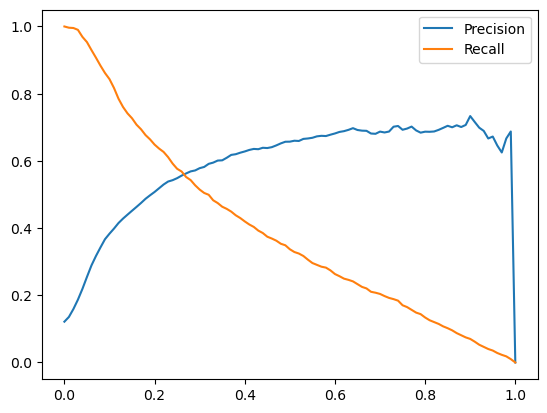

In [ ]:
plt.plot(df_pre_rec.t, df_pre_rec.precision, label='Precision')
plt.plot(df_pre_rec.t, df_pre_rec.recall, label='Recall')
plt.legend()

**Question 4: F1 score**

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.02
*0.22
*0.42
*0.62

In [ ]:
def f1score(pr, rc):
    f1 = (2 * pr * rc)/(pr + rc)
    return f1

In [ ]:
df_pre_rec['f1score'] = f1score(df_pre_rec.precision, df_pre_rec.recall)

In [ ]:
max_f1score_row = df_pre_rec.loc[df_pre_rec['f1score'].idxmax()]

print('Threshold: %s, F1Score: %s'%(max_f1score_row['t'], max_f1score_row['f1score']))

Threshold: 0.22, F1Score: 0.5740508969545266


**Question 5: 5-Fold CV**

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

* 0.0001
* 0.006
* 0.06
* 0.26

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [ ]:
n_splits =5

scores = []

for train_idx, val_idx in kfold.split(full_train):
    df_train = full_train.iloc[train_idx]
    df_val = full_train.iloc[val_idx]

    X_train = df_train.drop('y', axis=1)
    X_val = df_val.drop('y', axis=1)

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(X_train,y_train)
    y_pred = predict(X_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(np.std(scores))

0.005656168836598589


**Question 6: Hyperparameter Tuning**

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.000001, 0.001, 1]
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

* 0.000001
* 0.001
* 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [ ]:
n_splits = 5

for c in tqdm([0.000001, 0.001, 1]):

    scores = []

    for train_idx, val_idx in kfold.split(full_train):
        df_train = full_train.iloc[train_idx]
        df_val = full_train.iloc[val_idx]

        X_train = df_train.drop('y', axis=1)
        X_val = df_val.drop('y', axis=1)

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train,y_train, C=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C:%s Mean: %.3f' % (c, np.mean(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C:1e-06 Mean: 0.702
C:0.001 Mean: 0.986
C:1 Mean: 1.000
